# Klasifikacija: Heart_Disease (1.4–2.3)

Ta zvezek združuje:

- **1.4 Bivariatno analizo** (povezave med X in `Heart_Disease`)
- **1.5 Izbor spremenljivk (feature selection)** (RF importance, Elastic Net, RFE)
- **2.1–2.3 Gradnjo in ocenjevanje modelov** (80/20 split, 5 modelov, 10-fold CV, metrike + grafi)

> Opomba: Podatki so neuravnoteženi (razred `Heart_Disease=Yes` je redkejši), zato rezultate pokažemo **(A) brez uteževanja** in **(B) z uteževanjem razredov** (`class_weight="balanced"`).


# 1.4 Bivariatna analiza – **klasifikacija** (Heart_Disease)

V tej točki preverimo povezavo **vsake neodvisne spremenljivke** z odvisno spremenljivko **Heart_Disease** (`Yes/No`).

- Uporabljeni so *ustrezni statistični testi* glede na tip spremenljivk (po “cheat sheet-u”).
- Dodani so tudi osnovni grafični prikazi.
- Na koncu izpišemo **skupno tabelo** z rezultati (test, statistika, p-vrednost, mera učinka).

> Opomba: Ker je vzorec zelo velik (N ≈ 309k), bodo p-vrednosti pogosto zelo majhne; zato v interpretaciji poleg p-vrednosti vedno gledamo tudi **mero učinka** (npr. Cramérjev V, Cohenov d, rank-biserial r).


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

# -------------------------
# Nastavitve
# -------------------------
CSV_PATH = "CVD_cleaned.csv"  # privzeto ime datoteke
# fallback (če uporabljaš drugačno ime v repo):
if not Path(CSV_PATH).exists() and Path("CVD_cleaned_v2.csv").exists():
    CSV_PATH = "CVD_cleaned_v2.csv"   # če je datoteka v repo root; po potrebi popravi pot
TARGET = "Heart_Disease"
RANDOM_STATE = 42

SAVE_FIGS = True
FIG_DIR = Path("figures/1_4_classification")
FIG_DIR.mkdir(parents=True, exist_ok=True)

ALPHA = 0.05  # prag značilnosti


In [38]:
# -------------------------
# (Opcijsko) vrstni red kategorij za lepše grafe
# Če slovar pustiš prazen {}, se bo uporabil privzet (abecedni) vrstni red.
# -------------------------
CATEGORY_ORDER = {
    "General_Health": ["Poor", "Fair", "Good", "Very Good", "Excellent"],
    "Age_Category": ["18-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80+"],
    "Checkup": ["Within the past year","Within the past 2 years","Within the past 5 years","5 or more years ago","Never"],
    "Sex": ["Female","Male"],
    "Exercise": ["No","Yes"],
    "Smoking_History": ["No","Yes"],
    "Skin_Cancer": ["No","Yes"],
    "Other_Cancer": ["No","Yes"],
    "Depression": ["No","Yes"],
    "Arthritis": ["No","Yes"],
    # Diabetes ima več kategorij → pustimo brez vsiljenega vrstnega reda (lahko dodaš, če želiš)
}


In [39]:
# -------------------------
# Nalaganje podatkov
# -------------------------
assert Path(CSV_PATH).exists(), f"Ne najdem datoteke: {CSV_PATH} (preveri pot/ime)"
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
display(df.head())

# Ciljna spremenljivka
print("\nPorazdelitev ciljne spremenljivke (Heart_Disease):")
display(df[TARGET].value_counts())
display((df[TARGET].value_counts(normalize=True)*100).round(3))


Shape: (308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0



Porazdelitev ciljne spremenljivke (Heart_Disease):


Heart_Disease
No     283883
Yes     24971
Name: count, dtype: int64

Heart_Disease
No     91.915
Yes     8.085
Name: proportion, dtype: float64

## Logika izbire statističnih testov (po tipu spremenljivk)

### A) Kategorialna (X) vs. kategorialna (Y)
- Uporabimo **χ² test neodvisnosti**.
- Če je kontingenčna tabela **2×2** in so pričakovane frekvence **< 5**, uporabimo **Fisherjev eksaktni test**.
- Mera učinka: **Cramérjev V**.

### B) Numerična (X) vs. binarna kategorialna (Y)
Ker ima `Heart_Disease` dve skupini (`Yes`/`No`), primerjamo porazdelitev numerične spremenljivke med skupinama:

1. Preverimo **normalnost** (Shapiro-Wilk na vzorcu do 5000 primerov na skupino).
2. Če je normalnost OK, preverimo **enakost varianc** (Levenov test na vzorcu).
3. Izbira testa:
   - normalno + enake variance → **Studentov t-test**
   - normalno + neenake variance → **Welchov t-test**
   - sicer → **Mann–Whitney U test** (neparametrični)

Mere učinka:
- t-test → **Cohenov d**
- Mann–Whitney → **rank-biserial r**

### Grafi
- numerične spremenljivke: **boxplot** po skupinah `Heart_Disease`
- kategorialne spremenljivke: **delež “Yes” po kategorijah** (barplot)


In [40]:
# -------------------------
# Pomožne funkcije
# -------------------------
def safe_name(s: str) -> str:
    # Za varna imena datotek (odstrani posebne znake)
    return (
        s.replace("(", "")
         .replace(")", "")
         .replace("/", "_")
         .replace("\\", "_")
         .replace(" ", "_")
         .replace("__", "_")
         .replace(":", "")
         .replace("%", "pct")
    )

def _sample_series(s: pd.Series, n: int, random_state: int = 42) -> pd.Series:
    s = s.dropna()
    if len(s) <= n:
        return s
    return s.sample(n=n, random_state=random_state)

def normality_p(s: pd.Series, max_n: int = 5000, random_state: int = 42) -> float:
    # Shapiro-Wilk normalnost na vzorcu (do max_n)
    s2 = _sample_series(s, max_n, random_state)
    if len(s2) < 3:
        return np.nan
    return float(stats.shapiro(s2)[1])

def levene_p(g1: pd.Series, g2: pd.Series, max_n: int = 5000, random_state: int = 42) -> float:
    # Levenov test enakosti varianc (na vzorcih)
    a = _sample_series(g1, max_n, random_state).values
    b = _sample_series(g2, max_n, random_state).values
    if len(a) < 2 or len(b) < 2:
        return np.nan
    return float(stats.levene(a, b, center="median")[1])

def cramers_v(ct: pd.DataFrame) -> float:
    # Cramérjev V (mera učinka) za χ² test
    chi2 = stats.chi2_contingency(ct, correction=False)[0]
    n = ct.values.sum()
    r, k = ct.shape
    if n == 0 or min(r, k) <= 1:
        return np.nan
    return float(np.sqrt((chi2 / n) / (min(r - 1, k - 1))))

def cohens_d(x: pd.Series, y: pd.Series) -> float:
    # Cohenov d (mera učinka) za dve skupini
    x = x.dropna().astype(float)
    y = y.dropna().astype(float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    sp = np.sqrt(((nx - 1) * sx**2 + (ny - 1) * sy**2) / (nx + ny - 2))
    if sp == 0:
        return np.nan
    return float((x.mean() - y.mean()) / sp)

def rank_biserial_from_u(u: float, n1: int, n2: int) -> float:
    # Rank-biserial r iz Mann-Whitney U
    if n1 == 0 or n2 == 0:
        return np.nan
    return float(1 - (2*u)/(n1*n2))

def plot_box_by_binary(x: pd.Series, y: pd.Series, x_name: str, y_name: str, save_path=None):
    # Boxplot numerične spremenljivke po binarni ciljki
    y_clean = y.dropna()
    levels = ["No", "Yes"] if set(y_clean.unique()) == {"No","Yes"} else sorted(y_clean.unique(), key=str)
    data = [x[y == lvl].dropna().astype(float).values for lvl in levels]

    plt.figure()
    plt.boxplot(data, tick_labels=[str(l) for l in levels], vert=True, showfliers=True)
    plt.title(f"{x_name} po {y_name}")
    plt.xlabel(y_name)
    plt.ylabel(x_name)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close()
    else:
        plt.show()

def plot_yes_rate_by_category(x: pd.Series, y: pd.Series, x_name: str, y_name: str, save_path=None, max_cats: int = 30, order=None):
    # Barplot: delež pozitivnega razreda (Yes) po kategorijah
    tmp = pd.DataFrame({x_name: x, y_name: y}).dropna()
    y_bin = tmp[y_name].map({"Yes": 1, "No": 0})
    tmp = tmp.assign(_ybin=y_bin)

    grp = tmp.groupby(x_name)["_ybin"].agg(["mean","count"]).sort_values("count", ascending=False)

    # Če imamo podan vrstni red kategorij (ordinalne spremenljivke), ga uporabimo za smiselnejši graf
    if order is not None:
        order_present = [o for o in order if o in grp.index]
        rest = [i for i in grp.index if i not in order_present]
        grp = grp.loc[order_present + rest]

    if len(grp) > max_cats:
        grp = grp.head(max_cats)

    plt.figure(figsize=(8, 4))
    plt.bar(grp.index.astype(str), grp["mean"]*100)
    plt.title(f"Delež '{y_name}=Yes' po {x_name}")
    plt.ylabel("Delež Yes (%)")
    plt.xticks(rotation=45, ha="right")
    for i, (idx, row) in enumerate(grp.iterrows()):
        plt.text(i, row["mean"]*100, f"n={int(row['count'])}", ha="center", va="bottom", fontsize=8, rotation=90)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close()
    else:
        plt.show()


In [41]:
# -------------------------
# Tipi spremenljivk (v tem naboru)
# -------------------------
numeric_cols = [
    "Height_(cm)",
    "Weight_(kg)",
    "BMI",
    "Alcohol_Consumption",
    "Fruit_Consumption",
    "Green_Vegetables_Consumption",
    "FriedPotato_Consumption",
]

categorical_cols = [c for c in df.columns if c not in numeric_cols + [TARGET]]

print("Numerične:", numeric_cols)
print("Kategorialne:", categorical_cols)


Numerične: ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
Kategorialne: ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']


In [42]:
# -------------------------
# Bivariatna analiza: X vs Heart_Disease
# -------------------------
results = []
y = df[TARGET]

# 1) NUMERIČNE: t-test / Welch / Mann-Whitney
for x_name in numeric_cols:
    x = df[x_name]
    g_no  = x[y == "No"]
    g_yes = x[y == "Yes"]

    # normalnost na vzorcih
    p_norm_no  = normality_p(g_no,  max_n=5000, random_state=RANDOM_STATE)
    p_norm_yes = normality_p(g_yes, max_n=5000, random_state=RANDOM_STATE)
    normal = (p_norm_no > ALPHA) and (p_norm_yes > ALPHA)

    # enakost varianc
    p_lev = levene_p(g_no, g_yes, max_n=5000, random_state=RANDOM_STATE)
    equal_var = (p_lev > ALPHA) if not np.isnan(p_lev) else False

    if normal and equal_var:
        stat, pval = stats.ttest_ind(g_no, g_yes, equal_var=True, nan_policy="omit")
        test_name = "Studentov t-test"
        effect = cohens_d(g_no, g_yes)
        effect_name = "Cohenov d"
        note = f"Normalnost OK (p={p_norm_no:.3f}, {p_norm_yes:.3f}); Levene p={p_lev:.3f}."
    elif normal and not equal_var:
        stat, pval = stats.ttest_ind(g_no, g_yes, equal_var=False, nan_policy="omit")
        test_name = "Welchov t-test"
        effect = cohens_d(g_no, g_yes)
        effect_name = "Cohenov d"
        note = f"Normalnost OK; varianca neenaka (Levene p={p_lev:.3f})."
    else:
        stat, pval = stats.mannwhitneyu(g_no.dropna(), g_yes.dropna(), alternative="two-sided", method="auto")
        test_name = "Mann–Whitney U"
        effect = rank_biserial_from_u(stat, g_no.dropna().shape[0], g_yes.dropna().shape[0])
        effect_name = "Rank-biserial r"
        note = f"Normalnost ni OK (p={p_norm_no:.3f}, {p_norm_yes:.3f}) → neparametrični test."

    if SAVE_FIGS:
        pth = FIG_DIR / f"box_{safe_name(x_name)}.png"
        plot_box_by_binary(x, y, x_name, TARGET, pth)

    results.append({
        "X": x_name,
        "Tip X": "numerična",
        "Test": test_name,
        "Statistika": float(stat),
        "p": float(pval),
        "Mera učinka": effect_name,
        "Učinek": float(effect),
        "Opomba": note,
        "N_No": int(g_no.notna().sum()),
        "N_Yes": int(g_yes.notna().sum()),
        "No_mean": float(g_no.mean()),
        "Yes_mean": float(g_yes.mean()),
        "No_median": float(g_no.median()),
        "Yes_median": float(g_yes.median()),
    })

# 2) KATEGORIALNE: χ² / Fisher
for x_name in categorical_cols:
    x = df[x_name]
    ct = pd.crosstab(x, y)

    chi2, p_chi, dof, expected = stats.chi2_contingency(ct, correction=False)
    exp_min = float(np.min(expected))

    if ct.shape == (2, 2) and exp_min < 5:
        oddsratio, pval = stats.fisher_exact(ct.values)
        test_name = "Fisherjev eksaktni test (2×2)"
        stat = oddsratio
        note = f"Pričakovane frekvence < 5 (min={exp_min:.3f})."
        effect = np.nan
        effect_name = "—"
    else:
        test_name = "χ² test neodvisnosti"
        stat = chi2
        pval = p_chi
        note = f"dof={dof}, min pričakovane={exp_min:.3f}"
        effect = cramers_v(ct)
        effect_name = "Cramérjev V"

    if SAVE_FIGS:
        pth = FIG_DIR / f"bar_{safe_name(x_name)}.png"
        plot_yes_rate_by_category(x, y, x_name, TARGET, pth, order=CATEGORY_ORDER.get(x_name))

    results.append({
        "X": x_name,
        "Tip X": "kategorialna",
        "Test": test_name,
        "Statistika": float(stat),
        "p": float(pval),
        "Mera učinka": effect_name,
        "Učinek": float(effect) if effect == effect else np.nan,
        "Opomba": note,
        "N_No": int((y == "No").sum()),
        "N_Yes": int((y == "Yes").sum()),
        "No_mean": np.nan,
        "Yes_mean": np.nan,
        "No_median": np.nan,
        "Yes_median": np.nan,
    })

biv_table = pd.DataFrame(results)
# (Priporočilo) Popravek p-vrednosti za večkratno testiranje (Benjamini–Hochberg / FDR)
# Pri velikem N je veliko p-vrednosti zelo majhnih; FDR pomaga, da ne "preveč" označimo vsega kot pomembno.
def benjamini_hochberg(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals, dtype=float)
    n = pvals.size
    order = np.argsort(pvals)
    ranked = np.empty(n, dtype=float)
    ranked[order] = np.arange(1, n+1)
    q = pvals * n / ranked
    # monotonicity
    q_sorted = q[order]
    q_sorted = np.minimum.accumulate(q_sorted[::-1])[::-1]
    q_adj = np.empty(n, dtype=float)
    q_adj[order] = np.clip(q_sorted, 0, 1)
    return q_adj

biv_table["p_FDR"] = benjamini_hochberg(biv_table["p"].values)

biv_table["abs_effect"] = biv_table["Učinek"].abs()
biv_table = biv_table.sort_values(["p", "abs_effect"], ascending=[True, False]).reset_index(drop=True)

display(biv_table.head(10))


,X,Tip X,Test,Statistika,p,Mera učinka,Učinek,Opomba,N_No,N_Yes,No_mean,Yes_mean,No_median,Yes_median,p_FDR,abs_effect
0,General_Health,kategorialna,χ² test neodvisnosti,1.923433e+04,0.0,Cramérjev V,0.249553,"dof=4, min pričakovane=916.117",283883,24971,NaN,NaN,NaN,NaN,0.0,0.249553
1,Age_Category,kategorialna,χ² test neodvisnosti,1.803593e+04,0.0,Cramérjev V,0.241653,"dof=12, min pričakovane=1252.698",283883,24971,NaN,NaN,NaN,NaN,0.0,0.241653
2,Diabetes,kategorialna,χ² test neodvisnosti,1.041855e+04,0.0,Cramérjev V,0.183665,"dof=3, min pričakovane=213.930",283883,24971,NaN,NaN,NaN,NaN,0.0,0.183665
3,Arthritis,kategorialna,χ² test neodvisnosti,7.316549e+03,0.0,Cramérjev V,0.153913,"dof=1, min pričakovane=8171.641",283883,24971,NaN,NaN,NaN,NaN,0.0,0.153913
4,Alcohol_Consumption,numerična,Mann–Whitney U,4.082698e+09,0.0,Rank-biserial r,-0.151866,"Normalnost ni OK (p=0.000, 0.000) → neparametr...",283883,24971,5.185298,4.085339,1.0,0.0,0.0,0.151866
5,Smoking_History,kategorialna,χ² test neodvisnosti,3.588941e+03,0.0,Cramérjev V,0.107797,"dof=1, min pričakovane=10127.657",283883,24971,NaN,NaN,NaN,NaN,0.0,0.107797
6,Exercise,kategorialna,χ² test neodvisnosti,2.867001e+03,0.0,Cramérjev V,0.096347,"dof=1, min pričakovane=5616.927",283883,24971,NaN,NaN,NaN,NaN,0.0,0.096347
7,Checkup,kategorialna,χ² test neodvisnosti,2.731044e+03,0.0,Cramérjev V,0.094035,"dof=4, min pričakovane=113.757",283883,24971,NaN,NaN,NaN,NaN,0.0,0.094035
8,Other_Cancer,kategorialna,χ² test neodvisnosti,2.636184e+03,0.0,Cramérjev V,0.092387,"dof=1, min pričakovane=2415.651",283883,24971,NaN,NaN,NaN,NaN,0.0,0.092387
9,Skin_Cancer,kategorialna,χ² test neodvisnosti,2.549111e+03,0.0,Cramérjev V,0.090848,"dof=1, min pričakovane=2425.030",283883,24971,NaN,NaN,NaN,NaN,0.0,0.090848


In [43]:
# -------------------------
# Hitri povzetek ključnih povezav (za interpretacijo v poročilu)
# -------------------------
# Top kategorialne po Cramérjevem V
cat = biv_table[(biv_table["Tip X"]=="kategorialna") & (biv_table["Mera učinka"]=="Cramérjev V")].copy()
top_cat = cat.sort_values("Učinek", ascending=False).head(5)

print("TOP 5 kategorialnih spremenljivk (po Cramérjev V):")
display(top_cat[["X","Učinek","p","Test","Opomba"]])

# Za vsako top kategorialno pokažemo kategorije z najvišjim deležem Heart_Disease=Yes
for x_name in top_cat["X"]:
    tmp = df[[x_name, TARGET]].dropna()
    rate = tmp.assign(_y=tmp[TARGET].map({"Yes":1,"No":0})).groupby(x_name)["_y"].agg(["mean","count"])
    rate = rate.sort_values("mean", ascending=False).head(5)
    print(f"\n{x_name}: kategorije z najvišjim deležem Heart_Disease=Yes")
    display((rate.assign(Yes_pct=(rate["mean"]*100).round(2))
                 .drop(columns=["mean"])
                 .rename(columns={"count":"n"})))

# Top numerične po |rank-biserial r| ali |Cohen d|
num = biv_table[biv_table["Tip X"]=="numerična"].copy()
num["abs_eff"] = num["Učinek"].abs()
top_num = num.sort_values("abs_eff", ascending=False).head(5)

print("\nTOP 5 numeričnih spremenljivk (po absolutni meri učinka):")
display(top_num[["X","Učinek","Mera učinka","p","Test","No_median","Yes_median","No_mean","Yes_mean"]])


TOP 5 kategorialnih spremenljivk (po Cramérjev V):


,X,Učinek,p,Test,Opomba
0,General_Health,0.249553,0.0,χ² test neodvisnosti,"dof=4, min pričakovane=916.117"
1,Age_Category,0.241653,0.0,χ² test neodvisnosti,"dof=12, min pričakovane=1252.698"
2,Diabetes,0.183665,0.0,χ² test neodvisnosti,"dof=3, min pričakovane=213.930"
3,Arthritis,0.153913,0.0,χ² test neodvisnosti,"dof=1, min pričakovane=8171.641"
5,Smoking_History,0.107797,0.0,χ² test neodvisnosti,"dof=1, min pričakovane=10127.657"



General_Health: kategorije z najvišjim deležem Heart_Disease=Yes


,n,Yes_pct
General_Health,,
Poor,11331,31.79
Fair,35810,18.96
Good,95364,9.06
Very Good,110395,4.37
Excellent,55954,1.99



Age_Category: kategorije z najvišjim deležem Heart_Disease=Yes


,n,Yes_pct
Age_Category,,
80+,22271,21.80
75-79,20705,18.12
70-74,31103,14.66
65-69,33434,11.43
60-64,32418,9.29



Diabetes: kategorije z najvišjim deležem Heart_Disease=Yes


,n,Yes_pct
Diabetes,,
Yes,40171,20.85
"No, pre-diabetes or borderline diabetes",6896,11.51
No,259141,6.06
"Yes, but female told only during pregnancy",2646,3.63



Arthritis: kategorije z najvišjim deležem Heart_Disease=Yes


,n,Yes_pct
Arthritis,,
Yes,101071,14.10
No,207783,5.16



Smoking_History: kategorije z najvišjim deležem Heart_Disease=Yes


,n,Yes_pct
Smoking_History,,
Yes,125264,11.64
No,183590,5.66



TOP 5 numeričnih spremenljivk (po absolutni meri učinka):


,X,Učinek,Mera učinka,p,Test,No_median,Yes_median,No_mean,Yes_mean
4,Alcohol_Consumption,-0.151866,Rank-biserial r,0.000000e+00,Mann–Whitney U,1.00,0.00,5.185298,4.085339
11,Weight_(kg),0.109072,Rank-biserial r,2.695694e-180,Mann–Whitney U,81.19,83.91,83.298262,86.889986
12,BMI,0.106681,Rank-biserial r,1.934898e-172,Mann–Whitney U,27.44,28.55,28.543676,29.564505
14,Green_Vegetables_Consumption,-0.057551,Rank-biserial r,3.777408e-52,Mann–Whitney U,12.00,10.00,15.216878,13.900404
15,FriedPotato_Consumption,-0.049621,Rank-biserial r,1.863347e-39,Mann–Whitney U,4.00,4.00,6.320104,6.029594


In [44]:
# -------------------------
# Izvoz skupne tabele
# -------------------------
OUT_CSV = "1_4_bivariatna_analiza_klasifikacija.csv"
biv_table.drop(columns=["abs_effect"]).to_csv(OUT_CSV, index=False)
print("Shranjeno:", OUT_CSV)

print("\nSlike so shranjene v mapi:", FIG_DIR)


Shranjeno: 1_4_bivariatna_analiza_klasifikacija.csv

Slike so shranjene v mapi: figures\1_4_classification


## Kako interpretirati rezultate

- **p-vrednost**: statistična značilnost povezave (pri velikem N bo pogosto zelo majhna).
- **mera učinka** (bolj “procesno” relevantno):
  - **Cramérjev V**: ~0 (zanemarljivo), ~0.1 (majhno), ~0.3 (srednje), ~0.5 (veliko) *(pravilo palca)*.
  - **Cohenov d**: ~0.2 (majhen), ~0.5 (srednji), ~0.8 (velik).
  - **rank-biserial r**: blizu 0 (majhen), proti ±1 (velik).

V nadaljevanju (1.5 Feature Selection) lahko kot kandidatske spremenljivke vzamemo tiste z:
- najnižjimi p-vrednostmi **in/ali**
- največjimi absolutnimi merami učinka.


## 1.5 Izbor spremenljivk (Feature Selection)

Uporabimo **tri metode**:
1) **Random Forest importance** (na ordinalno kodiranih kategorialnih spremenljivkah)  
2) **Logistic regression z Elastic Net** (na one-hot kodiranih spremenljivkah; pomembnost = |koeficient|)  
3) **RFE** (Recursive Feature Elimination) z logistično regresijo (na ordinalno kodiranih spremenljivkah)

Za hitrost je pri metodah 1)–3) uporabljena **stratificirana podmnožica** (nastavljivo s `FS_SAMPLE_SIZE`).  
Na koncu izberemo **TOP spremenljivke**, ki jih vključimo v modele v poglavju 2.x.


,rf_importance,elasticnet_importance,rfe_score,combined_score
Age_Category,0.135958,12.157759,1.000000,1.000000
Diabetes,0.051106,0.697637,1.000000,0.452587
BMI,0.119851,0.096135,0.500000,0.437485
Alcohol_Consumption,0.050868,0.025402,1.000000,0.433501
Arthritis,0.033004,0.326706,1.000000,0.392677
Sex,0.026938,0.893336,1.000000,0.391548
Smoking_History,0.023184,0.405691,1.000000,0.367861
Checkup,0.015194,0.663517,1.000000,0.352977
Depression,0.017634,0.335316,1.000000,0.350682
Exercise,0.018085,0.042335,1.000000,0.343887


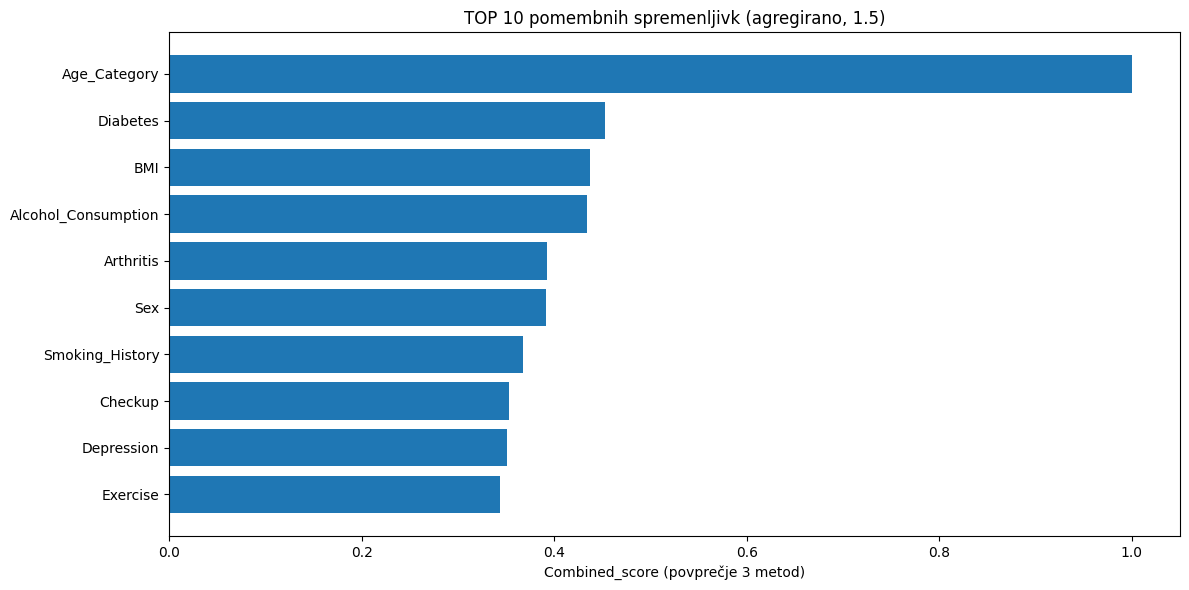

['Age_Category',
 'Diabetes',
 'BMI',
 'Alcohol_Consumption',
 'Arthritis',
 'Sex',
 'Smoking_History',
 'Checkup',
 'Depression',
 'Exercise']

In [45]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# -------------------------
# Priprava podatkov
# -------------------------
# y: Yes/No -> 1/0
y_full = (df[TARGET] == "Yes").astype(int)

X_full = df.drop(columns=[TARGET])

# Nastavljivo: podvzorčenje za feature selection (zaradi hitrosti).
FS_SAMPLE_SIZE = 60000  # None = uporabi vse (lahko traja zelo dolgo)

if FS_SAMPLE_SIZE is not None and FS_SAMPLE_SIZE < len(df):
    X_fs, _, y_fs, _ = train_test_split(
        X_full, y_full,
        train_size=FS_SAMPLE_SIZE,
        stratify=y_full,
        random_state=RANDOM_STATE
    )
else:
    X_fs, y_fs = X_full, y_full

# ločimo tipe
num_fs = [c for c in numeric_cols if c in X_fs.columns]
cat_fs = [c for c in categorical_cols if c in X_fs.columns]

feature_names_base = num_fs + cat_fs

# -------------------------
# 1) RandomForest importance (ordinal encoding za kategorialne)
# -------------------------
preprocess_ord = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_fs),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_fs),
    ],
    remainder="drop"
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=14,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[("preprocess", preprocess_ord), ("model", rf)])
rf_pipe.fit(X_fs, y_fs)

rf_importance = pd.Series(rf_pipe.named_steps["model"].feature_importances_, index=feature_names_base)

# -------------------------
# 2) Elastic Net logistic regression (one-hot za kategorialne)
# -------------------------
preprocess_ohe = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_fs),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_fs),
    ],
    remainder="drop"
)

# robustna nastavitev zaradi razlik med verzijami sklearn
def make_elasticnet_lr(class_weight=None):
    try:
        return LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            l1_ratio=0.15,
            C=0.8,
            max_iter=2000,
            random_state=RANDOM_STATE,
            class_weight=class_weight,
            n_jobs=-1
        )
    except TypeError:
        return LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            l1_ratio=0.15,
            C=0.8,
            max_iter=2000,
            random_state=RANDOM_STATE,
            class_weight=class_weight
        )

enet_lr = make_elasticnet_lr(class_weight="balanced")
enet_pipe = Pipeline(steps=[("preprocess", preprocess_ohe), ("model", enet_lr)])
enet_pipe.fit(X_fs, y_fs)

ohe = enet_pipe.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(cat_fs))
enet_feature_names = num_fs + ohe_feature_names

coef = enet_pipe.named_steps["model"].coef_.ravel()
enet_abs = pd.Series(np.abs(coef), index=enet_feature_names)

# agregacija nazaj na osnovne spremenljivke
enet_importance = pd.Series(0.0, index=feature_names_base)

for c in num_fs:
    enet_importance[c] = enet_abs.get(c, 0.0)

for c in cat_fs:
    mask = [name.startswith(f"{c}_") for name in ohe_feature_names]
    enet_importance[c] = enet_abs[ohe_feature_names].loc[np.array(mask)].sum()

# -------------------------
# 3) RFE (na ordinalno kodiranih spremenljivkah -> izbor baznih spremenljivk)
# -------------------------
X_fs_ord = preprocess_ord.fit_transform(X_fs)

rfe_lr = LogisticRegression(
    solver="liblinear",
    penalty="l2",
    C=1.0,
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

RFE_N_SELECT = 10
rfe = RFE(estimator=rfe_lr, n_features_to_select=RFE_N_SELECT, step=1)
rfe.fit(X_fs_ord, y_fs)

rfe_ranking = pd.Series(rfe.ranking_, index=feature_names_base)
rfe_score = 1.0 / rfe_ranking

# -------------------------
# Normalizacija + agregacija (povprečje metod)
# -------------------------
def minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series(0.0, index=s.index)
    return (s - s.min()) / (s.max() - s.min())

rf_n = minmax(rf_importance)
enet_n = minmax(enet_importance)
rfe_n = minmax(rfe_score)

combined = (rf_n + enet_n + rfe_n) / 3.0

fs_table = pd.DataFrame({
    "rf_importance": rf_importance,
    "elasticnet_importance": enet_importance,
    "rfe_score": rfe_score,
    "combined_score": combined
}).sort_values("combined_score", ascending=False)

display(fs_table.head(15))

fs_table.to_csv("1_5_feature_selection_klasifikacija.csv", index=True)

# TOP 10 graf
import matplotlib.pyplot as plt

top10 = fs_table.head(10).iloc[::-1]
plt.figure(figsize=(12, 6))
plt.barh(top10.index, top10["combined_score"])
plt.title("TOP 10 pomembnih spremenljivk (agregirano, 1.5)")
plt.xlabel("Combined_score (povprečje 3 metod)")
plt.tight_layout()
plt.savefig("feature_selection_top10.png", dpi=150)
plt.show()

# Končna izbira spremenljivk za modele
SELECT_TOP_K = 10
selected_features = list(fs_table.head(SELECT_TOP_K).index)
selected_features


## 2. Drugi del: Gradnja in ocenjevanje modelov (klasifikacija)

### 2.1 Priprava podatkov
- Razdelitev **80% učna** / **20% testna** (stratificirano).
- Podatki niso časovno odvisni → naključna delitev.

### 2.2 Modeli (≥5)
Uporabimo 5 različnih algoritmov (vsi z eksplicitno nastavljenimi hiperparametri), med njimi obvezno **logistično regresijo**:
- LogisticRegression
- LinearSVC
- SGDClassifier (log-loss)
- RandomForestClassifier
- ExtraTreesClassifier

### 2.3 Metrike in 10-fold CV
Izračunamo: **AUC, Accuracy, Sensitivity, Specificity, PPV, NPV, F1** (mean ± SD čez 10 foldov) + grafična primerjava.

Nato ponovimo še z **uteževanjem razredov** (`class_weight="balanced"`).


Razmerje razredov (train): 0.0809 (delež Yes)
Razmerje razredov (test):  0.0808 (delež Yes)


###############################
# CV: brez uteževanja (unweighted)
###############################

=== Model 1/5: LogisticRegression ===
  - fold 01/10 done in 1.0s | overall 1/50 | avg/fit 1.0s
  - fold 02/10 done in 0.8s | overall 2/50 | avg/fit 0.9s
  - fold 03/10 done in 0.9s | overall 3/50 | avg/fit 0.9s
  - fold 04/10 done in 0.9s | overall 4/50 | avg/fit 0.9s
  - fold 05/10 done in 0.7s | overall 5/50 | avg/fit 0.9s
  - fold 06/10 done in 0.9s | overall 6/50 | avg/fit 0.9s
  - fold 07/10 done in 0.9s | overall 7/50 | avg/fit 0.9s
  - fold 08/10 done in 0.9s | overall 8/50 | avg/fit 0.9s
  - fold 09/10 done in 0.7s | overall 9/50 | avg/fit 0.8s
  - fold 10/10 done in 0.9s | overall 10/50 | avg/fit 0.8s
=== LogisticRegression končan (trajanje: 8.4s) ===

=== Model 2/5: LinearSVC ===
  - fold 01/10 done in 0.9s | overall 11/50 | avg/fit 0.9s
  - fold 02/10 done in 0.9s | overall 12/50 | a

C:\Users\krist\AppData\Local\Temp\ipykernel_19544\230922006.py:89: RuntimeWarning: Mean of empty slice
  return f"{np.nanmean(x):.3f} ± {np.nanstd(x):.3f}"
C:\Users\krist\AppData\Roaming\Python\Python39\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


  - fold 01/10 done in 1.0s | overall 21/50 | avg/fit 0.9s
  - fold 02/10 done in 0.9s | overall 22/50 | avg/fit 0.9s
  - fold 03/10 done in 0.9s | overall 23/50 | avg/fit 0.9s
  - fold 04/10 done in 1.0s | overall 24/50 | avg/fit 0.9s
  - fold 05/10 done in 0.9s | overall 25/50 | avg/fit 0.9s
  - fold 06/10 done in 0.9s | overall 26/50 | avg/fit 0.9s
  - fold 07/10 done in 1.1s | overall 27/50 | avg/fit 0.9s
  - fold 08/10 done in 0.9s | overall 28/50 | avg/fit 0.9s
  - fold 09/10 done in 0.9s | overall 29/50 | avg/fit 0.9s
  - fold 10/10 done in 1.0s | overall 30/50 | avg/fit 0.9s
=== SGDClassifier končan (trajanje: 9.5s) ===

=== Model 4/5: ExtraTrees ===
  - fold 01/10 done in 18.6s | overall 31/50 | avg/fit 1.5s
  - fold 02/10 done in 18.8s | overall 32/50 | avg/fit 2.0s
  - fold 03/10 done in 18.9s | overall 33/50 | avg/fit 2.5s
  - fold 04/10 done in 19.1s | overall 34/50 | avg/fit 3.0s
  - fold 05/10 done in 19.3s | overall 35/50 | avg/fit 3.5s
  - fold 06/10 done in 20.2s | ov

,Model,Tip,Parametri,AUC (mean±SD),Accuracy (mean±SD),Sensitivity (mean±SD),Specificity (mean±SD),PPV (mean±SD),NPV (mean±SD),F1 (mean±SD),Komentar,Izbor
0,LogisticRegression,LogisticRegression,"solver=lbfgs, penalty=l2, C=0.8, max_iter=500,...",0.810 ± 0.005,0.919 ± 0.001,0.025 ± 0.004,0.997 ± 0.000,0.461 ± 0.061,0.921 ± 0.000,0.047 ± 0.008,"Zelo visoka specifičnost, a model skoraj ne za...",DA
1,LinearSVC,LinearSVC,"C=1.2, max_iter=3000, class_weight=None, dual=...",0.808 ± 0.005,0.919 ± 0.000,0.000 ± 0.000,1.000 ± 0.000,nan ± nan,0.919 ± 0.000,0.000 ± 0.000,"Zelo visoka specifičnost, a model skoraj ne za...",DA
2,SGDClassifier,SGDClassifier,"loss=log_loss, penalty=elasticnet, alpha=0.000...",0.809 ± 0.005,0.919 ± 0.001,0.028 ± 0.012,0.997 ± 0.001,0.441 ± 0.065,0.921 ± 0.001,0.052 ± 0.022,"Zelo visoka specifičnost, a model skoraj ne za...",DA
3,ExtraTrees,ExtraTreesClassifier,"n_estimators=200, max_depth=16, min_samples_sp...",0.806 ± 0.005,0.919 ± 0.000,0.002 ± 0.001,1.000 ± 0.000,0.436 ± 0.191,0.919 ± 0.000,0.005 ± 0.002,"Zelo visoka specifičnost, a model skoraj ne za...",
4,RandomForest,RandomForestClassifier,"n_estimators=200, max_depth=14, min_samples_sp...",0.806 ± 0.005,0.919 ± 0.000,0.005 ± 0.002,1.000 ± 0.000,0.479 ± 0.136,0.919 ± 0.000,0.010 ± 0.003,"Zelo visoka specifičnost, a model skoraj ne za...",




###############################
# CV: z uteževanjem (weighted)
###############################

=== Model 1/5: LogisticRegression ===
  - fold 01/10 done in 0.9s | overall 1/50 | avg/fit 0.9s
  - fold 02/10 done in 1.0s | overall 2/50 | avg/fit 1.0s
  - fold 03/10 done in 1.0s | overall 3/50 | avg/fit 1.0s
  - fold 04/10 done in 1.0s | overall 4/50 | avg/fit 1.0s
  - fold 05/10 done in 1.0s | overall 5/50 | avg/fit 1.0s
  - fold 06/10 done in 1.1s | overall 6/50 | avg/fit 1.0s
  - fold 07/10 done in 1.0s | overall 7/50 | avg/fit 1.0s
  - fold 08/10 done in 1.0s | overall 8/50 | avg/fit 1.0s
  - fold 09/10 done in 0.9s | overall 9/50 | avg/fit 1.0s
  - fold 10/10 done in 0.8s | overall 10/50 | avg/fit 1.0s
=== LogisticRegression končan (trajanje: 9.9s) ===

=== Model 2/5: LinearSVC ===
  - fold 01/10 done in 1.2s | overall 11/50 | avg/fit 1.0s
  - fold 02/10 done in 1.1s | overall 12/50 | avg/fit 1.0s
  - fold 03/10 done in 1.1s | overall 13/50 | avg/fit 1.0s
  - fold 04/10 done in 1.

,Model,Tip,Parametri,AUC (mean±SD),Accuracy (mean±SD),Sensitivity (mean±SD),Specificity (mean±SD),PPV (mean±SD),NPV (mean±SD),F1 (mean±SD),Komentar,Izbor
0,LogisticRegression,LogisticRegression,"solver=lbfgs, penalty=l2, C=0.8, max_iter=500,...",0.810 ± 0.005,0.706 ± 0.003,0.777 ± 0.009,0.700 ± 0.004,0.185 ± 0.003,0.973 ± 0.001,0.299 ± 0.004,"Visoka občutljivost, a več lažno pozitivnih (n...",DA
1,LinearSVC,LinearSVC,"C=1.2, max_iter=3000, class_weight=balanced, d...",0.810 ± 0.005,0.701 ± 0.004,0.784 ± 0.008,0.694 ± 0.004,0.184 ± 0.003,0.973 ± 0.001,0.298 ± 0.004,"Visoka občutljivost, a več lažno pozitivnih (n...",DA
2,SGDClassifier,SGDClassifier,"loss=log_loss, penalty=elasticnet, alpha=0.000...",0.808 ± 0.004,0.699 ± 0.035,0.778 ± 0.049,0.692 ± 0.043,0.183 ± 0.012,0.973 ± 0.004,0.296 ± 0.012,"Visoka občutljivost, a več lažno pozitivnih (n...",DA
3,ExtraTrees,ExtraTreesClassifier,"n_estimators=200, max_depth=16, min_samples_sp...",0.804 ± 0.005,0.726 ± 0.004,0.740 ± 0.009,0.725 ± 0.004,0.192 ± 0.003,0.969 ± 0.001,0.304 ± 0.004,"Visoka občutljivost, a več lažno pozitivnih (n...",
4,RandomForest,RandomForestClassifier,"n_estimators=200, max_depth=14, min_samples_sp...",0.803 ± 0.005,0.742 ± 0.004,0.711 ± 0.013,0.744 ± 0.004,0.196 ± 0.004,0.967 ± 0.001,0.308 ± 0.005,"Visoka občutljivost, a več lažno pozitivnih (n...",


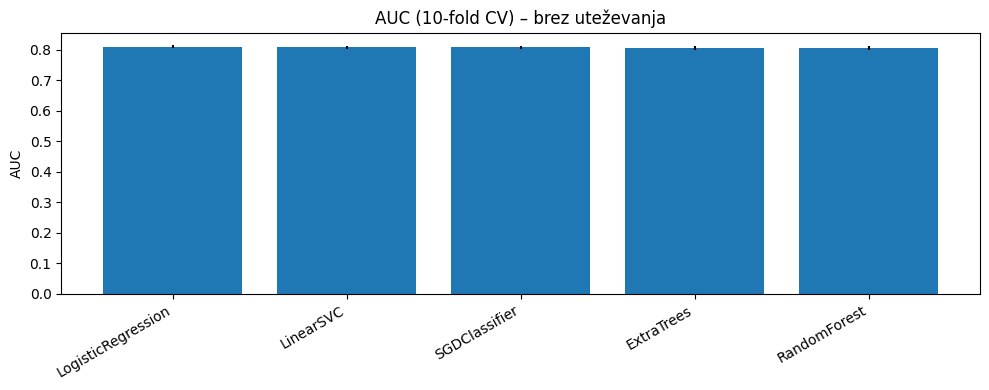

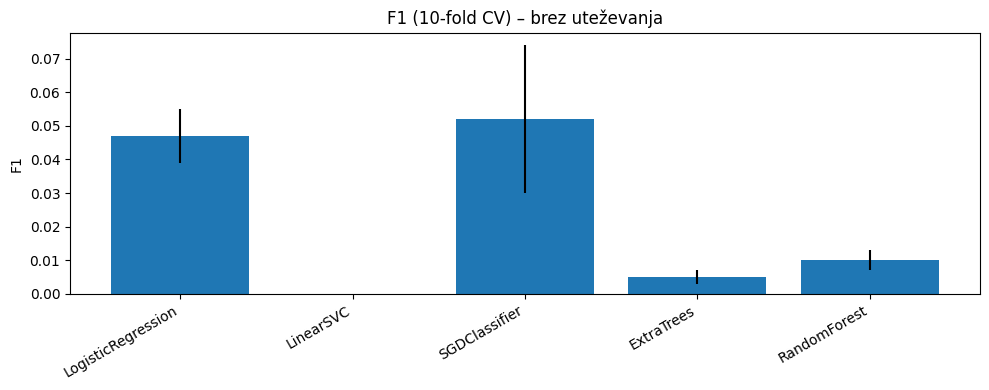

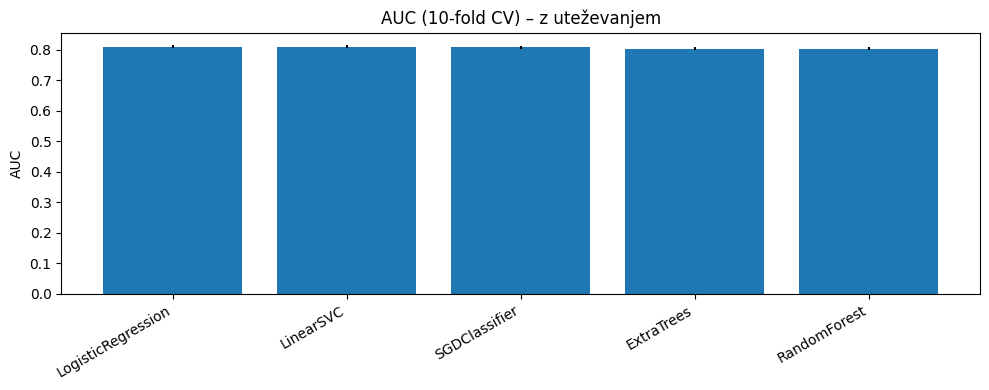

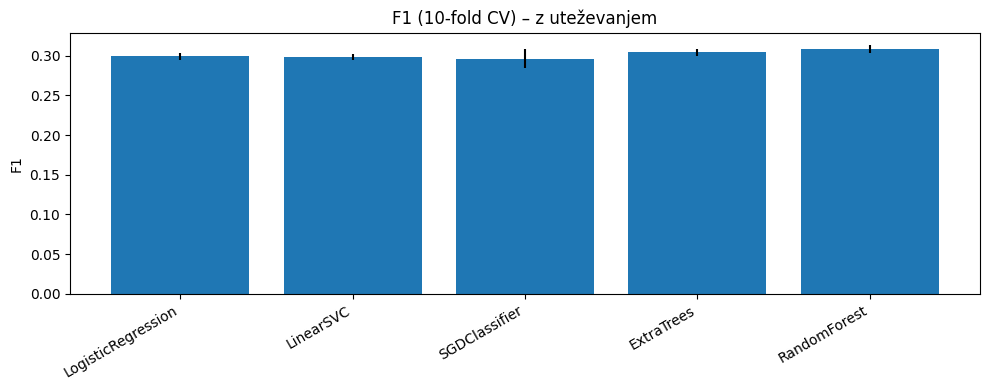

In [47]:
import numpy as np
import pandas as pd
from pathlib import Path
import time

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

# ============================================================
# HITREJŠE nastavitve (še vedno 10-fold CV!)
# ============================================================
N_SPLITS = 10

# Če imaš RANDOM_STATE že definiran zgoraj, to vrstico izbriši
RANDOM_STATE = 42

# GOZDOVI so najpočasnejši -> zmanjšamo št. dreves + subsampling
RF_N_ESTIMATORS = 200
ET_N_ESTIMATORS = 200
TREE_SUBSAMPLE = 0.7      # delež vrstic na drevo (hitreje), zahteva bootstrap=True

PRINT_EVERY_FOLD = True   # izpis napredka

# -------------------------
# 2.1 Split (80/20)
# -------------------------
y = (df[TARGET] == "Yes").astype(int)
X = df[selected_features].copy()

num_cols_sel = [c for c in selected_features if c in numeric_cols]
cat_cols_sel = [c for c in selected_features if c in categorical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Razmerje razredov (train):", round(float(y_train.mean()), 4), "(delež Yes)")
print("Razmerje razredov (test): ", round(float(y_test.mean()), 4), "(delež Yes)")

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_sel),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_sel),
    ],
    remainder="drop"
)

# -------------------------
# Metrike + helperji
# -------------------------
def get_scores(pipe: Pipeline, X_val):
    # OPTIMIZACIJA: preprocess transform naredimo samo 1x
    Xt = pipe.named_steps["preprocess"].transform(X_val)
    model = pipe.named_steps["model"]

    y_pred = model.predict(Xt)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xt)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(Xt)
    else:
        y_score = y_pred
    return y_pred, y_score

def compute_metrics(y_true, y_pred, y_score):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv  = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv  = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_score)

    return {"AUC": auc, "Accuracy": acc, "Sensitivity": sens, "Specificity": spec, "PPV": ppv, "NPV": npv, "F1": f1}

def mean_sd(x):
    return f"{np.nanmean(x):.3f} ± {np.nanstd(x):.3f}"

def params_short(est):
    p = est.get_params()
    if est.__class__.__name__ == "LogisticRegression":
        keys = ["solver", "penalty", "C", "max_iter", "class_weight"]
    elif est.__class__.__name__ == "LinearSVC":
        keys = ["C", "max_iter", "class_weight", "dual"]
    elif est.__class__.__name__ == "SGDClassifier":
        keys = ["loss", "penalty", "alpha", "l1_ratio", "max_iter", "class_weight"]
    elif est.__class__.__name__ in ["RandomForestClassifier", "ExtraTreesClassifier"]:
        keys = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
                "max_features", "bootstrap", "max_samples", "class_weight"]
    else:
        keys = list(p.keys())[:6]
    return ", ".join([f"{k}={p.get(k)}" for k in keys])

def build_models(balanced: bool):
    cw = "balanced" if balanced else None
    return {
        "LogisticRegression": LogisticRegression(
            solver="lbfgs",
            penalty="l2",          # kompatibilno (ne uporabljaj 'none')
            C=0.8,
            max_iter=500,
            random_state=RANDOM_STATE,
            class_weight=cw
        ),
        "LinearSVC": LinearSVC(
            C=1.2,
            class_weight=cw,
            max_iter=3000,
            dual=False,            # pri malo feature-ih pogosto hitreje
            random_state=RANDOM_STATE
        ),
        "SGDClassifier": SGDClassifier(
            loss="log_loss",
            penalty="elasticnet",
            alpha=1e-4,
            l1_ratio=0.15,
            max_iter=1500,
            tol=1e-3,
            class_weight=cw,
            random_state=RANDOM_STATE
        ),
        "ExtraTrees": ExtraTreesClassifier(
            n_estimators=ET_N_ESTIMATORS,
            max_depth=16,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features="sqrt",
            bootstrap=True,
            max_samples=TREE_SUBSAMPLE,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight=cw
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=RF_N_ESTIMATORS,
            max_depth=14,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features="sqrt",
            bootstrap=True,
            max_samples=TREE_SUBSAMPLE,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight=("balanced_subsample" if balanced else None)
        )
    }

def cv_evaluate(models: dict, X_tr, y_tr, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    rows = []
    fold_details = {}

    t_all = time.perf_counter()
    total_fits = len(models) * n_splits
    done = 0

    for mi, (name, est) in enumerate(models.items(), start=1):
        print(f"\n=== Model {mi}/{len(models)}: {name} ===")
        t_model = time.perf_counter()

        fold_metrics = []
        for fold, (i_tr, i_va) in enumerate(skf.split(X_tr, y_tr), start=1):
            t_fold = time.perf_counter()

            X_train_f, X_val_f = X_tr.iloc[i_tr], X_tr.iloc[i_va]
            y_train_f, y_val_f = y_tr.iloc[i_tr], y_tr.iloc[i_va]

            pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clone(est))])
            pipe.fit(X_train_f, y_train_f)

            y_pred, y_score = get_scores(pipe, X_val_f)
            m = compute_metrics(y_val_f, y_pred, y_score)
            m["fold"] = fold
            fold_metrics.append(m)

            done += 1
            if PRINT_EVERY_FOLD:
                fold_s = time.perf_counter() - t_fold
                elapsed = time.perf_counter() - t_all
                avg = elapsed / done
                print(f"  - fold {fold:02d}/{n_splits} done in {fold_s:.1f}s | overall {done}/{total_fits} | avg/fit {avg:.1f}s")

        fold_df = pd.DataFrame(fold_metrics)
        fold_details[name] = fold_df

        summary = {
            "Model": name,
            "Tip": type(est).__name__,
            "Parametri": params_short(est),
            "AUC (mean±SD)": mean_sd(fold_df["AUC"]),
            "Accuracy (mean±SD)": mean_sd(fold_df["Accuracy"]),
            "Sensitivity (mean±SD)": mean_sd(fold_df["Sensitivity"]),
            "Specificity (mean±SD)": mean_sd(fold_df["Specificity"]),
            "PPV (mean±SD)": mean_sd(fold_df["PPV"]),
            "NPV (mean±SD)": mean_sd(fold_df["NPV"]),
            "F1 (mean±SD)": mean_sd(fold_df["F1"]),
        }
        rows.append(summary)

        model_s = time.perf_counter() - t_model
        print(f"=== {name} končan (trajanje: {model_s:.1f}s) ===")

    return fold_details, pd.DataFrame(rows)

def add_comments_and_choice(df_summary: pd.DataFrame):
    comments = []
    for _, r in df_summary.iterrows():
        sens = float(r["Sensitivity (mean±SD)"].split("±")[0].strip())
        spec = float(r["Specificity (mean±SD)"].split("±")[0].strip())
        f1   = float(r["F1 (mean±SD)"].split("±")[0].strip())

        if sens < 0.20 and spec > 0.95:
            comments.append("Zelo visoka specifičnost, a model skoraj ne zazna pozitivnih (mnogo FN).")
        elif sens > 0.70 and spec < 0.80:
            comments.append("Visoka občutljivost, a več lažno pozitivnih (nižja specifičnost).")
        elif f1 > 0.30:
            comments.append("Bolj uravnotežen kompromis (boljši F1) pri neuravnoteženih razredih.")
        else:
            comments.append("Srednji kompromis med občutljivostjo in specifičnostjo.")

    df_summary = df_summary.copy()
    df_summary["Komentar"] = comments

    auc_mean = df_summary["AUC (mean±SD)"].apply(lambda s: float(s.split("±")[0].strip()))
    top3 = auc_mean.rank(ascending=False, method="first") <= 3
    df_summary["Izbor"] = np.where(top3, "DA", "")
    return df_summary

Path("figures/2_classification").mkdir(parents=True, exist_ok=True)

# -------------------------
# (A) Brez uteževanja
# -------------------------
print("\n\n###############################")
print("# CV: brez uteževanja (unweighted)")
print("###############################")
models_unweighted = build_models(balanced=False)
folds_u, summary_u = cv_evaluate(models_unweighted, X_train, y_train, n_splits=N_SPLITS)
summary_u = add_comments_and_choice(summary_u)
display(summary_u)

summary_u.to_csv("2_3_cv_tabela_klasifikacija_unweighted.csv", index=False)

# -------------------------
# (B) Z uteževanjem
# -------------------------
print("\n\n###############################")
print("# CV: z uteževanjem (weighted)")
print("###############################")
models_weighted = build_models(balanced=True)
folds_w, summary_w = cv_evaluate(models_weighted, X_train, y_train, n_splits=N_SPLITS)
summary_w = add_comments_and_choice(summary_w)
display(summary_w)

summary_w.to_csv("2_3_cv_tabela_klasifikacija_weighted.csv", index=False)

# -------------------------
# Grafi: AUC in F1
# -------------------------
import matplotlib.pyplot as plt

def plot_metric(summary_df, metric_col, title, out_path):
    names = summary_df["Model"].tolist()
    means = [float(s.split("±")[0].strip()) for s in summary_df[metric_col]]
    sds   = [float(s.split("±")[1].strip()) for s in summary_df[metric_col]]

    plt.figure(figsize=(10, 4))
    plt.bar(names, means, yerr=sds)
    plt.xticks(rotation=30, ha="right")
    plt.title(title)
    plt.ylabel(metric_col.replace(" (mean±SD)", ""))
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

plot_metric(summary_u, "AUC (mean±SD)", "AUC (10-fold CV) – brez uteževanja", "figures/2_classification/cv_auc_unweighted.png")
plot_metric(summary_u, "F1 (mean±SD)",  "F1 (10-fold CV) – brez uteževanja",  "figures/2_classification/cv_f1_unweighted.png")

plot_metric(summary_w, "AUC (mean±SD)", "AUC (10-fold CV) – z uteževanjem",   "figures/2_classification/cv_auc_weighted.png")
plot_metric(summary_w, "F1 (mean±SD)",  "F1 (10-fold CV) – z uteževanjem",    "figures/2_classification/cv_f1_weighted.png")
